# Reinforce

#### Installing
```bash
pip install --user --upgrade tf-agents-nightly  # depends on tf-nightly
pip install tfp-nightly

```

#### References
* https://www.youtube.com/watch?v=tqrcjHuNdmQ
* https://www.youtube.com/watch?v=S_gwYj1Q-44
* https://www.youtube.com/watch?v=-TTziY7EmUA
* https://www.youtube.com/watch?v=tAOApRQAgpc
* https://github.com/tensorflow/agents/tree/master/tf_agents/colabs
* https://github.com/tensorflow/agents/blob/master/tf_agents/colabs/6_reinforce_tutorial.ipynb
* https://pybullet.org/wordpress/

In [1]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()


# Set up a virtual display for rendering OpenAI gym environments.
#display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

env_name = "CartPole-v0" # @param {type:"string"}
num_iterations = 250 # @param {type:"integer"}
collect_episodes_per_iteration = 2 # @param {type:"integer"}
replay_buffer_capacity = 2000 # @param {type:"integer"}

fc_layer_params = (100,)

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 50 # @param {type:"integer"}

In [2]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [3]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [4]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()


In [5]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [6]:
def compute_avg_return(environment, policy, num_episodes=10):    
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


In [7]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [8]:
def collect_episode(environment, policy, num_episodes):

    episode_counter = 0
    environment.reset()

    while episode_counter < num_episodes:
        time_step = environment.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = environment.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)

        # Add trajectory to the replay buffer
        replay_buffer.add_batch(traj)

        if traj.is_boundary():
            episode_counter += 1

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

In [9]:
%%time

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few episodes using collect_policy and save to the replay buffer.
    collect_episode(
      train_env, tf_agent.collect_policy, collect_episodes_per_iteration)

    # Use data from the buffer and update the agent's network.
    experience = replay_buffer.gather_all()
    train_loss = tf_agent.train(experience)
    replay_buffer.clear()

    step = tf_agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 25: loss = -0.8151793479919434
step = 50: loss = -1.7070715427398682
step = 50: Average Return = 79.4000015258789
step = 75: loss = -0.3595294952392578
step = 100: loss = -0.17192602157592773
step = 100: Average Return = 180.10000610351562
step = 125: loss = -0.7265932559967041
step = 150: loss = 0.904111385345459
step = 150: Average Return = 200.0
step = 175: loss = -6.530677795410156
step = 200: loss = -1.1128530502319336
step = 200: Average Return = 200.0
step = 225: loss = -5.312502861022949
step = 250: loss = -4.514223575592041
step = 250: Average Return = 200.0
CPU times: user 5min 56s, sys: 11.2 s, total: 6min 7s
Wall time: 5min 10s


(29.375, 250)

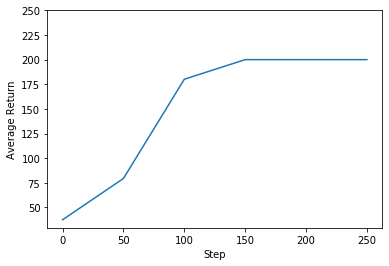

In [10]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)

In [11]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

In [12]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
    for _ in range(num_episodes):
        time_step = eval_env.reset()
        video.append_data(eval_py_env.render())
        while not time_step.is_last():
            action_step = tf_agent.policy.action(time_step)
            time_step = eval_env.step(action_step.action)
            video.append_data(eval_py_env.render())

embed_mp4(video_filename)

NoSuchDisplayException: Cannot connect to "None"